In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
import decoding_analysis_vis as dav
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy
import xarray as xr
sns.set_palette('colorblind')

No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [3]:
tmp = dav.SimpleSession(verbose=1, session_id=0, 
                        shuffle_trial_labels=False,
                        shuffle_timepoints=False,
                        shuffle_all_data=False,
                        prestim_baseline=False,
                        bool_filter_neurons=True)

                        

session name : 2020-09-04_RL093.pkl
Excluded 302 out of 2097 neurons


In [12]:
tmpr = tmp.dataset_selector(region='s1', min_t=-0.9, max_t=1.9, trial_type_list=['sensory', 'random'], 
                            deepcopy=True, remove_added_dimensions=True)  


In [22]:
# tmp.SesObj.photostim_r.all_trials[0].shape
tmp.SesObj.photostim_r.pre_trial_frames
# tmp.SesObj.photostim_r.fps

slice(8, 31, None)

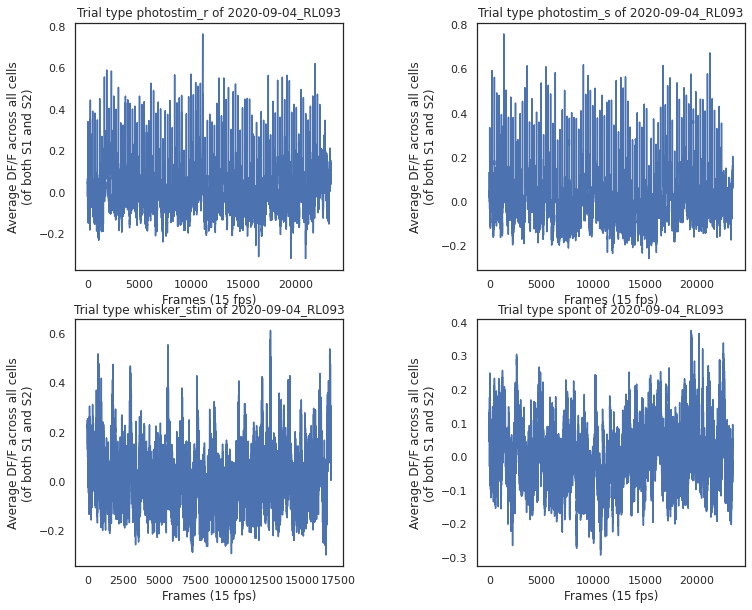

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'wspace': 0.5})

tt_list = ['photostim_r', 'photostim_s', 'whisker_stim', 'spont']

i_row, i_col = 0, 0
for i_tt, tt in enumerate(tt_list):
    curr_ax = ax[i_row, i_col]
    data_obj = getattr(tmp.SesObj, tt)
    curr_ax.plot(data_obj.dfof[0].mean(0))
    curr_ax.set_xlabel('Frames (15 fps)')
    curr_ax.set_ylabel('Average DF/F across all cells\n(of both S1 and S2)')
    curr_ax.set_title(f'Trial type {tt} of {tmp.session_name_readable}')
    i_col += 1
    if i_col ==2:
        i_row += 1
        i_col = 0

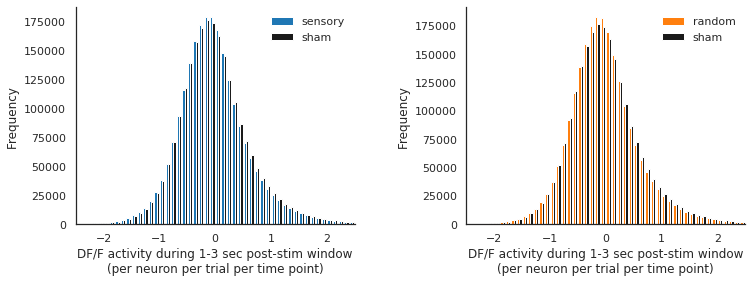

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.4})

for i_plot, tt2 in enumerate(['sensory', 'random']):
    dav.plot_distr_poststim_activity(ses=tmp, tt_list=[tt2, 'sham'], ax=ax[i_plot], plot_hist=True, plot_logscale=False)

[2321613. 2321622.]


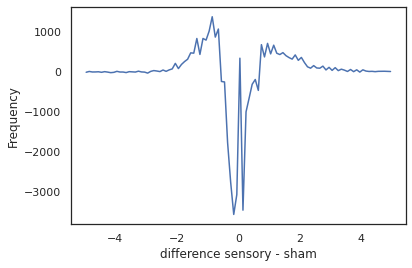

In [37]:
plt.plot((tmphist[1][1:] + tmphist[1][:-1]) * 0.5, tmphist[0][0, :] - tmphist[0][1, :])
plt.xlabel('difference sensory - sham')
plt.ylabel('Frequency')

print(tmphist[0].sum(1))

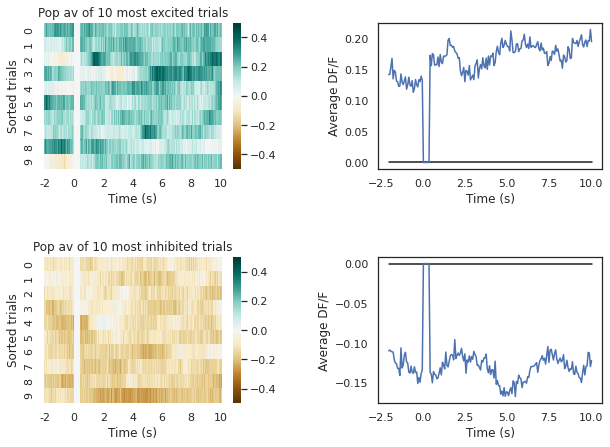

In [88]:
tmp_data = tmpr.activity.mean('neuron').data.transpose()
inds_sorted_trials = np.argsort(tmp_data.sum(1))[::-1]
tmp_data = tmp_data[inds_sorted_trials, :]
# print(tmp_data.shape)
fig, ax = plt.subplots(2, 2, figsize=(10, 7), gridspec_kw={'wspace': 0.5, 'hspace': 0.6})

n_trials = 10
for i_plot in range(2):
    if i_plot == 1:
        tmp_data_plot = tmp_data[-n_trials:, :]
        ax[i_plot, 0].set_title(f'Pop av of {n_trials} most inhibited trials')
    else:
        tmp_data_plot = tmp_data[:n_trials, :]
        ax[i_plot, 0].set_title(f'Pop av of {n_trials} most excited trials')
    sns.heatmap(tmp_data_plot, cmap='BrBG', ax=ax[i_plot, 0], vmin=-0.5, vmax=0.5)
    ax[i_plot, 0].set_ylabel('Sorted trials')
    ax[i_plot, 1].set_xlabel('Time (s)')
    ax[i_plot, 0].set_xticks([np.argmin(np.abs(tmpr.time.data - x)) for x in [-2, 0, 2, 4, 6, 8, 10]])
    ax[i_plot, 0].set_xticklabels([-2, 0, 2, 4, 6, 8, 10], rotation=0)
    ax[i_plot, 1].plot([tmpr.time[0], tmpr.time[-1]], [0, 0], c='k')
    ax[i_plot, 1].plot(tmpr.time, tmp_data_plot.mean(0))
    ax[i_plot, 0].set_xlabel('Time (s)')
    ax[i_plot, 1].set_ylabel('Average DF/F')

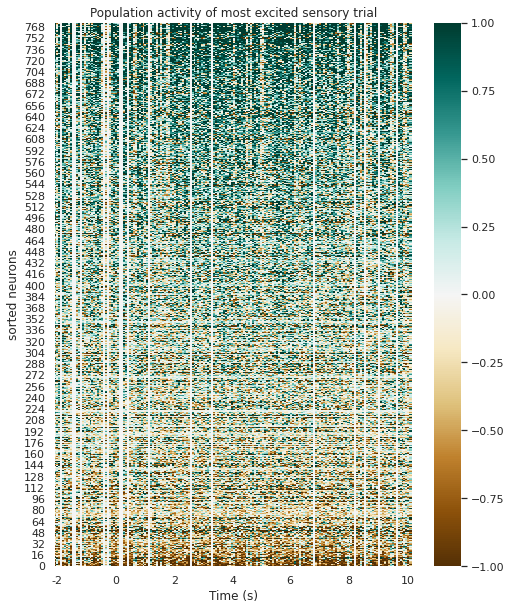

In [44]:
plot_data = tmpr.activity.isel(trial=inds_sorted_trials[0]).data
inds_sorted_neurons = np.argsort(plot_data.mean(1))
plot_data = plot_data[inds_sorted_neurons]

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
sns.heatmap(plot_data, cmap='BrBG', vmin=-1, vmax=1, ax=ax)
ax.set_ylabel('sorted neurons')
ax.set_xlabel('Time (s)')
dav.create_time_axis(ax=ax, time_arr=tmpr.time.data, label_list=[-2, 0, 2, 4, 6, 8, 10])
ax.set_title('Population activity of most excited sensory trial')
ax.invert_yaxis()

/home/tplas/anaconda3/envs/robs/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/tplas/anaconda3/envs/robs/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/tplas/anaconda3/envs/robs/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/tplas/anaconda3/envs/robs/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/tplas/anaconda3/envs/robs/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/tplas/anaconda3/envs/robs/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered 

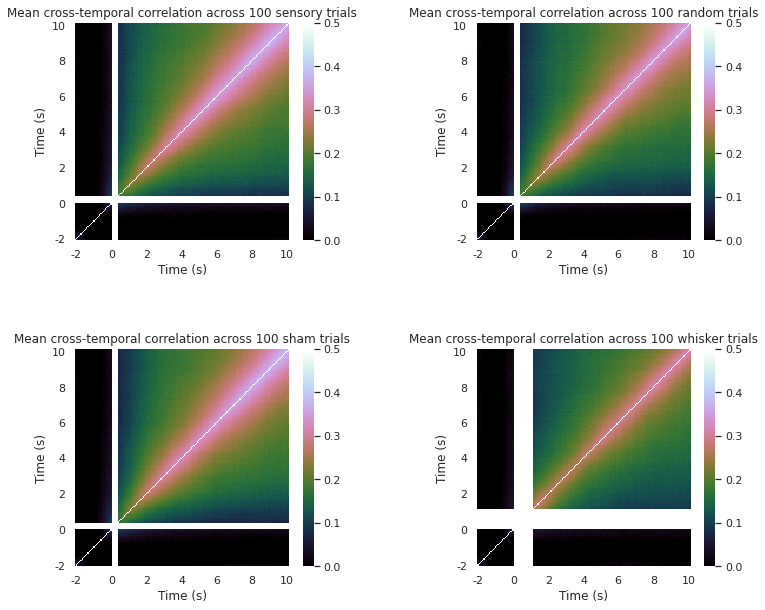

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
i_col, i_row = 0, 0 
for i_tt, tt in enumerate(['sensory', 'random', 'sham', 'whisker']):
    curr_ax = ax[i_row, i_col]
    dav.plot_cross_temp_corr(ds=tmpr.where(tmpr.trial_type == tt, drop=True), 
                             name=tt, ax=curr_ax)

    i_col += 1
    if i_col == 2:
        i_col = 0
        i_row += 1

/home/tplas/anaconda3/envs/robs/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/tplas/anaconda3/envs/robs/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/tplas/anaconda3/envs/robs/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/tplas/anaconda3/envs/robs/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'Mean sensory -  random cross-temporal correlation')

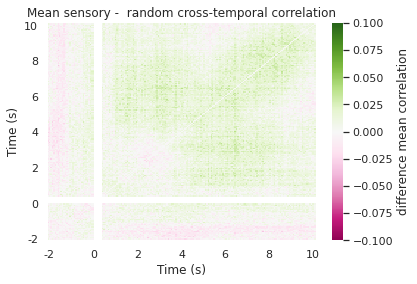

In [59]:
tt_1 = 'sensory'
tt_2 = 'random'

ds = tmpr.where(tmpr.trial_type == tt_1, drop=True)
tmpcor1 = np.stack([np.corrcoef(ds.activity.isel(trial=x).data.transpose()) for x in range(100)]).mean(0)
ds = tmpr.where(tmpr.trial_type == tt_2, drop=True)
tmpcor2 = np.stack([np.corrcoef(ds.activity.isel(trial=x).data.transpose()) for x in range(100)]).mean(0)

ax = plt.subplot(111)
sns.heatmap(tmpcor1 - tmpcor2, cmap='PiYG', vmin=-0.1, vmax=0.1, ax=ax,
            cbar_kws={'label': 'difference mean correlation'})
ax.invert_yaxis()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (s)')
dav.create_time_axis(ax=ax, time_arr=tmpr.time.data, axis='x')
dav.create_time_axis(ax=ax, time_arr=tmpr.time.data, axis='y')
ax.set_title(f'Mean {tt_1} -  {tt_2} cross-temporal correlation')

No handles with labels found to put in legend.


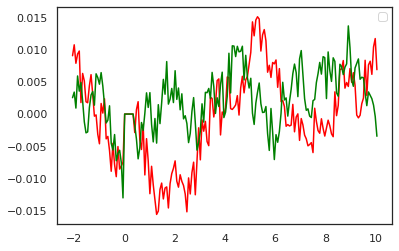

In [68]:
tmp_data_dict = {}
time_av_responses_dict = {}
tt_list = ['sensory', 'sham']
for i_tt, tt in enumerate(tt_list):
    tmp_data_dict[tt] = tmpr.activity.where(tmpr.trial_type == tt, drop=True).mean('neuron').data.transpose()
    inds_sorted_trials = np.argsort(tmp_data_dict[tt].sum(1))[::-1]
    tmp_data_dict[tt] = tmp_data_dict[tt][inds_sorted_trials, :]
    time_av_responses_dict[tt] = tmp_data_dict[tt][:, 45:75].mean(1)
    assert len(time_av_responses_dict[tt]) == 100


    if i_tt == 0:
        colour = 'red'
    else:
        colour = 'green'
    # plt.plot(tmp_data_dict[tt][:, :].transpose(), label=tt, alpha=0.7, c=colour)
    plt.plot(tmpr.time, tmp_data_dict[tt].mean(0), c=colour, label=tt)
# plt.hist([time_av_responses_dict[tt] for tt in tt_list], bins=np.linspace(-0.3, 0.3, 20), 
#             color=['red', 'green'], label=tt_list)

plt.legend()


In [4]:
tt_list = ['sensory', 'random']
p_val_dict = {tt: {} for tt in tt_list}
for i_s in tqdm(range(6)):
    tmp = dav.SimpleSession(verbose=1, sess_type='sens',
                            session_id=i_s, shuffle_trial_labels=False, bool_filter_neurons=True)
    for tt in tt_list:
        p_val_dict[tt][i_s] = dav.manual_poststim_response_classifier(Ses=tmp, plot_hist=False, tt_1=tt, n_shuffles=1000)

tt_list = ['projecting', 'non_projecting']
for tt in tt_list:
    p_val_dict[tt] = {}
for i_s in tqdm(range(6)):
    tmp = dav.SimpleSession(verbose=1, sess_type='proj',
                            session_id=i_s, shuffle_trial_labels=False, bool_filter_neurons=True)
    for tt in tt_list:
        p_val_dict[tt][i_s] = dav.manual_poststim_response_classifier(Ses=tmp, plot_hist=False, tt_1=tt, n_shuffles=1000)


  0%|          | 0/6 [00:00<?, ?it/s]

session name : 2020-09-04_RL093.pkl
Excluded 302 out of 2097 neurons
Number of correctly classified trials of sensory: 57
Number of correctly classified trials of sham: 47
Two-sided p value of sensory = 0.42364838043788555
Two-sided p value of sham = 0.3950124647636021


 17%|█▋        | 1/6 [00:58<04:50, 58.05s/it]

Number of correctly classified trials of random: 52
Number of correctly classified trials of sham: 45
Two-sided p value of random = 0.9901086108477812
Two-sided p value of sham = 0.10384278805402225
session name : 2020-09-08_RL099.pkl
Excluded 276 out of 2095 neurons
Number of correctly classified trials of sensory: 56
Number of correctly classified trials of sham: 50
Two-sided p value of sensory = 0.3710788071033573
Two-sided p value of sham = 0.5647229780207085


 33%|███▎      | 2/6 [01:30<02:52, 43.25s/it]

Number of correctly classified trials of random: 52
Number of correctly classified trials of sham: 53
Two-sided p value of random = 0.9908599195097553
Two-sided p value of sham = 0.7523599068686568
session name : 2020-09-14_RL101.pkl
Excluded 602 out of 2169 neurons
Number of correctly classified trials of sensory: 51
Number of correctly classified trials of sham: 55
Two-sided p value of sensory = 0.7803269607339786
Two-sided p value of sham = 0.4170571437875583


 50%|█████     | 3/6 [02:19<02:17, 45.70s/it]

Number of correctly classified trials of random: 54
Number of correctly classified trials of sham: 48
Two-sided p value of random = 0.6723919230533391
Two-sided p value of sham = 0.32148305372448616
session name : 2020-09-16_RL103.pkl
Excluded 461 out of 2106 neurons
Number of correctly classified trials of sensory: 58
Number of correctly classified trials of sham: 54
Two-sided p value of sensory = 0.1133468951778812
Two-sided p value of sham = 0.5672472032756881


 67%|██████▋   | 4/6 [02:59<01:27, 43.55s/it]

Number of correctly classified trials of random: 57
Number of correctly classified trials of sham: 59
Two-sided p value of random = 0.10618285904708866
Two-sided p value of sham = 0.023183160782386827
session name : 2020-10-02_RL108.pkl
Excluded 969 out of 2563 neurons
Number of correctly classified trials of sensory: 48
Number of correctly classified trials of sham: 54
Two-sided p value of sensory = 0.30160521498710435
Two-sided p value of sham = 0.6399070005131264


 83%|████████▎ | 5/6 [03:50<00:46, 46.15s/it]

Number of correctly classified trials of random: 56
Number of correctly classified trials of sham: 46
Two-sided p value of random = 0.4778689589328906
Two-sided p value of sham = 0.2761039433794177
session name : 2020-10-12_RL109.pkl
Excluded 843 out of 2515 neurons
Number of correctly classified trials of sensory: 48
Number of correctly classified trials of sham: 53
Two-sided p value of sensory = 0.26998272473431206
Two-sided p value of sham = 0.8383249848624424


  0%|          | 0/6 [00:00<?, ?it/s]

Number of correctly classified trials of random: 52
Number of correctly classified trials of sham: 46
Two-sided p value of random = 0.9732094281541674
Two-sided p value of sham = 0.1522101038602707
session name : 2021-02-18_RL127.pkl
Excluded 833 out of 2334 neurons
Number of correctly classified trials of projecting: 53
Number of correctly classified trials of sham: 48
Two-sided p value of projecting = 0.8344352783465349
Two-sided p value of sham = 0.24324220929512386


 17%|█▋        | 1/6 [00:37<03:07, 37.58s/it]

Number of correctly classified trials of non_projecting: 58
Number of correctly classified trials of sham: 49
Two-sided p value of non_projecting = 0.26589534159017036
Two-sided p value of sham = 0.5699800648274498
session name : 2021-02-22_RL128.pkl
Excluded 893 out of 2308 neurons
Number of correctly classified trials of projecting: 52
Number of correctly classified trials of sham: 54
Two-sided p value of projecting = 0.9439115964255264
Two-sided p value of sham = 0.5603289612206614


 33%|███▎      | 2/6 [01:12<02:25, 36.26s/it]

Number of correctly classified trials of non_projecting: 46
Number of correctly classified trials of sham: 54
Two-sided p value of non_projecting = 0.23095845744480115
Two-sided p value of sham = 0.7073593435749128
session name : 2021-02-23_RL129.pkl
Excluded 1323 out of 2364 neurons
Number of correctly classified trials of projecting: 52
Number of correctly classified trials of sham: 53
Two-sided p value of projecting = 0.9966236934963768
Two-sided p value of sham = 0.717199235522948


 50%|█████     | 3/6 [01:40<01:36, 32.14s/it]

Number of correctly classified trials of non_projecting: 48
Number of correctly classified trials of sham: 53
Two-sided p value of non_projecting = 0.2465091633634684
Two-sided p value of sham = 0.8543655649588862
session name : 2021-02-24_RL132.pkl
Excluded 757 out of 2156 neurons
Number of correctly classified trials of projecting: 49
Number of correctly classified trials of sham: 53
Two-sided p value of projecting = 0.3645099949165853
Two-sided p value of sham = 0.7946959261069806


 67%|██████▋   | 4/6 [02:08<01:01, 30.77s/it]

Number of correctly classified trials of non_projecting: 59
Number of correctly classified trials of sham: 54
Two-sided p value of non_projecting = 0.07171791811689814
Two-sided p value of sham = 0.6063924292746239
session name : 2021-02-25_RL131.pkl
Excluded 1361 out of 2448 neurons
Number of correctly classified trials of projecting: 51
Number of correctly classified trials of sham: 56
Two-sided p value of projecting = 0.7197340198265074
Two-sided p value of sham = 0.3101297145434764


 83%|████████▎ | 5/6 [02:34<00:28, 28.99s/it]

Number of correctly classified trials of non_projecting: 50
Number of correctly classified trials of sham: 51
Two-sided p value of non_projecting = 0.4519681454762343
Two-sided p value of sham = 0.7027137594909101
session name : 2021-03-02_RL130.pkl
Excluded 518 out of 2258 neurons
Number of correctly classified trials of projecting: 59
Number of correctly classified trials of sham: 50
Two-sided p value of projecting = 0.2044754853553764
Two-sided p value of sham = 0.6927669976315529


100%|██████████| 6/6 [03:14<00:00, 32.50s/it]

Number of correctly classified trials of non_projecting: 57
Number of correctly classified trials of sham: 49
Two-sided p value of non_projecting = 0.3197154843465013
Two-sided p value of sham = 0.5346671712125144


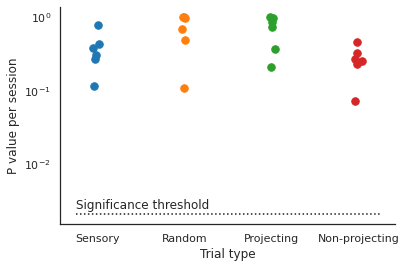

In [5]:
dav.plot_hist_p_vals_manual_decoders(p_val_dict=p_val_dict)

Classify based on average activity in post-stim window. 
- Construct a classifier manually (by using the average)

  0%|          | 0/6 [00:00<?, ?it/s]

session name : 2020-09-04_RL093.pkl
Excluded 302 out of 2097 neurons
Number of correctly classified trials of random: 52
Number of correctly classified trials of sham: 45
Two-sided p value of random = 0.9779503731003527
Two-sided p value of sham = 0.11494688538006195
Number of correctly classified trials of sensory: 57
Number of correctly classified trials of sham: 47


 17%|█▋        | 1/6 [01:24<07:04, 84.86s/it]

Two-sided p value of sensory = 0.4046196190950213
Two-sided p value of sham = 0.3843578480060411
session name : 2020-09-08_RL099.pkl
Excluded 276 out of 2095 neurons
Number of correctly classified trials of random: 52
Number of correctly classified trials of sham: 53
Two-sided p value of random = 0.9691353558637886
Two-sided p value of sham = 0.756965785429281
Number of correctly classified trials of sensory: 56
Number of correctly classified trials of sham: 50


 33%|███▎      | 2/6 [02:17<04:23, 65.99s/it]

Two-sided p value of sensory = 0.3477649322531349
Two-sided p value of sham = 0.5969237637348803
session name : 2020-09-14_RL101.pkl
Excluded 602 out of 2169 neurons
Number of correctly classified trials of random: 54
Number of correctly classified trials of sham: 48
Two-sided p value of random = 0.6286868827280401
Two-sided p value of sham = 0.33532746732377683


 50%|█████     | 3/6 [03:24<03:18, 66.26s/it]

Number of correctly classified trials of sensory: 51
Number of correctly classified trials of sham: 55
Two-sided p value of sensory = 0.757213108220843
Two-sided p value of sham = 0.4194770678172388
session name : 2020-09-16_RL103.pkl
Excluded 461 out of 2106 neurons
Number of correctly classified trials of random: 57
Number of correctly classified trials of sham: 59
Two-sided p value of random = 0.10123379916435321
Two-sided p value of sham = 0.02024476255136525
Number of correctly classified trials of sensory: 58
Number of correctly classified trials of sham: 54


 67%|██████▋   | 4/6 [04:16<02:01, 60.72s/it]

Two-sided p value of sensory = 0.08670444790236934
Two-sided p value of sham = 0.5880013591596992
session name : 2020-10-02_RL108.pkl
Excluded 969 out of 2563 neurons
Number of correctly classified trials of random: 56
Number of correctly classified trials of sham: 46
Two-sided p value of random = 0.48260793104384503
Two-sided p value of sham = 0.26845279336815775
Number of correctly classified trials of sensory: 48
Number of correctly classified trials of sham: 54


 83%|████████▎ | 5/6 [05:17<01:00, 60.85s/it]

Two-sided p value of sensory = 0.33426803046104514
Two-sided p value of sham = 0.6525015323878893
session name : 2020-10-12_RL109.pkl
Excluded 843 out of 2515 neurons
Number of correctly classified trials of random: 52
Number of correctly classified trials of sham: 46
Two-sided p value of random = 0.985450818706396
Two-sided p value of sham = 0.1527025474485296
Number of correctly classified trials of sensory: 48
Number of correctly classified trials of sham: 53


100%|██████████| 6/6 [06:08<00:00, 61.43s/it]

Two-sided p value of sensory = 0.28061284265856534
Two-sided p value of sham = 0.8023196278037852


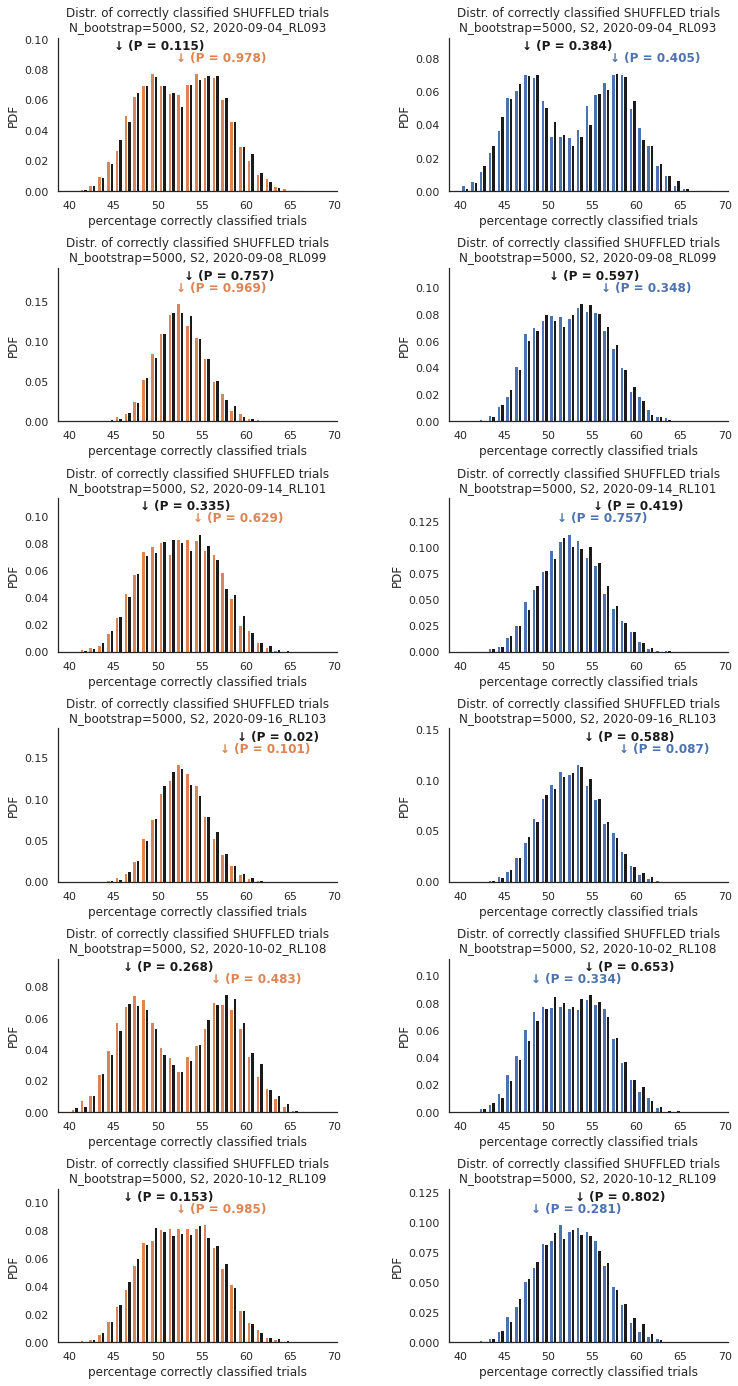

In [12]:
fig, ax = plt.subplots(6, 2, figsize=(12, 24), gridspec_kw={'wspace': 0.4, 'hspace': 0.5})

for i_s in tqdm(range(6)):
    tmp = dav.SimpleSession(verbose=1, sess_type='sens',
                            session_id=i_s, shuffle_trial_labels=False, bool_filter_neurons=True)
    dav.manual_poststim_response_classifier(Ses=tmp, ax=ax[i_s, 0], tt_1='random')
    dav.manual_poststim_response_classifier(Ses=tmp, ax=ax[i_s, 1], tt_1='sensory')

# plt.savefig('/home/tplas/repos/Vape/jupyter/thijs/figs/manual_classification_proj.pdf', bbox_to_anchor='tight')

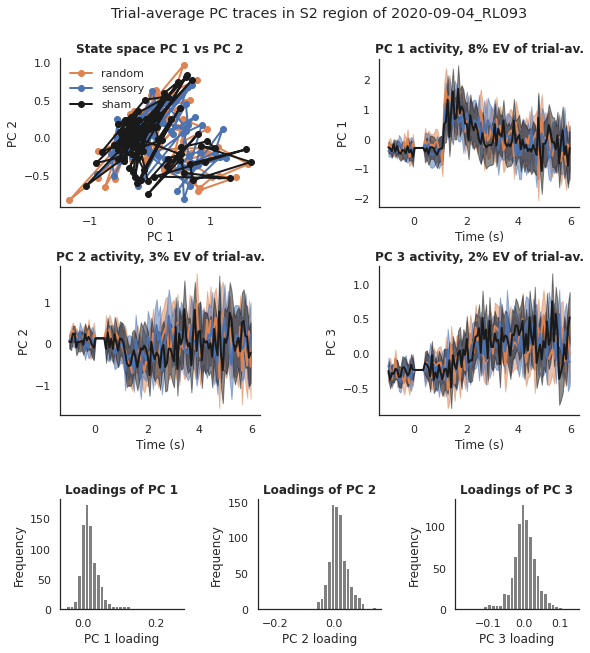

In [59]:
tmppca = dav.plot_pca_time_aggr_activity(Ses=tmp, trial_type_list=['sensory', 'random', 'sham'], 
                                         merge_trial_types_during_pca=True,
                                         plot_loadings=True,
                                         plot_indiv_trials=False,
                                         plot_ci=True, region='s2')

session name : 2020-09-04_RL093.pkl
Excluded 302 out of 2097 neurons
session name : 2020-09-08_RL099.pkl
Excluded 276 out of 2095 neurons
session name : 2020-09-14_RL101.pkl
Excluded 602 out of 2169 neurons
session name : 2020-09-16_RL103.pkl
Excluded 461 out of 2106 neurons
session name : 2020-10-02_RL108.pkl
Excluded 969 out of 2563 neurons
session name : 2020-10-12_RL109.pkl
Excluded 843 out of 2515 neurons


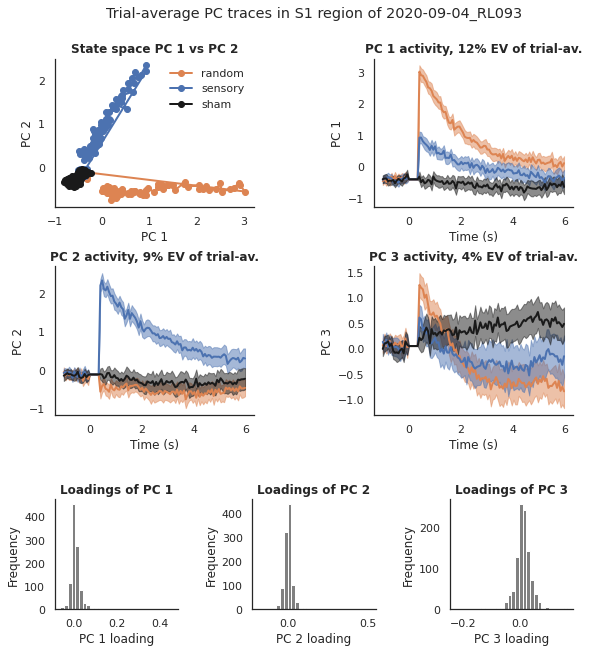

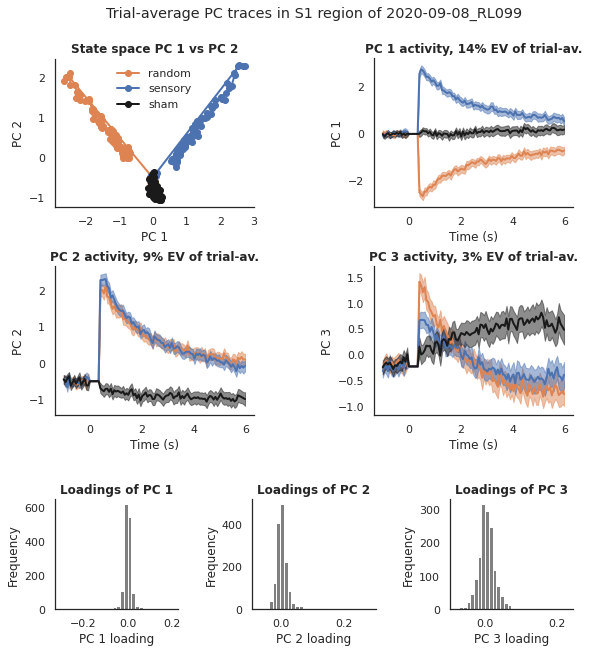

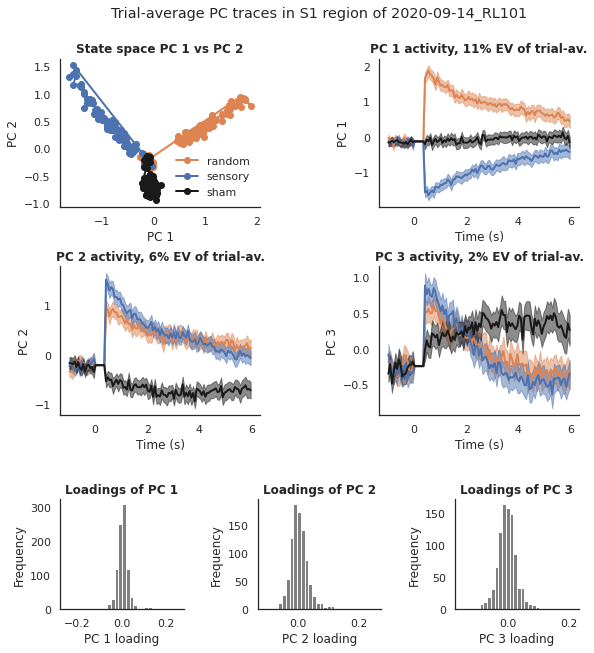

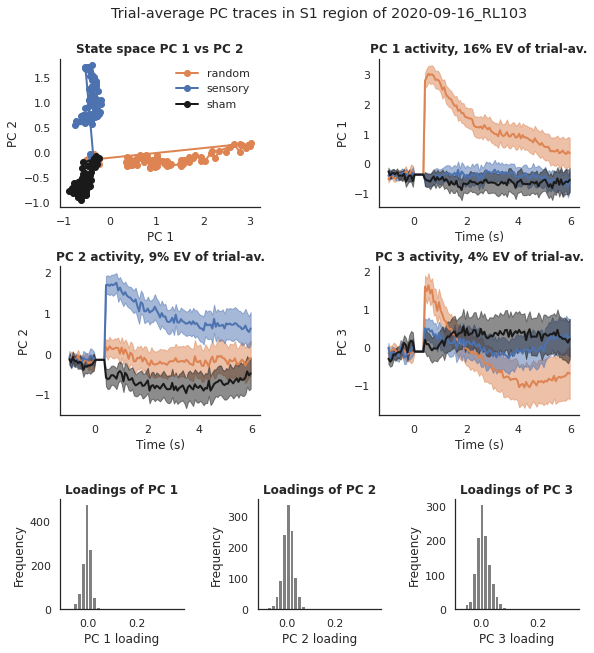

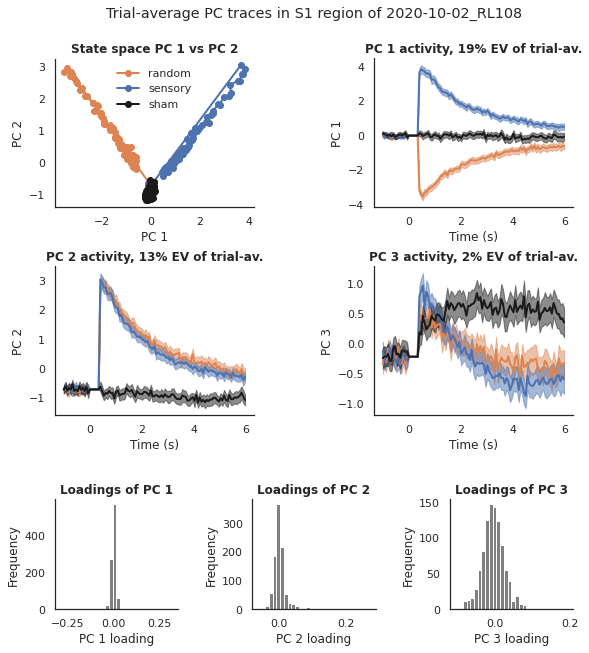

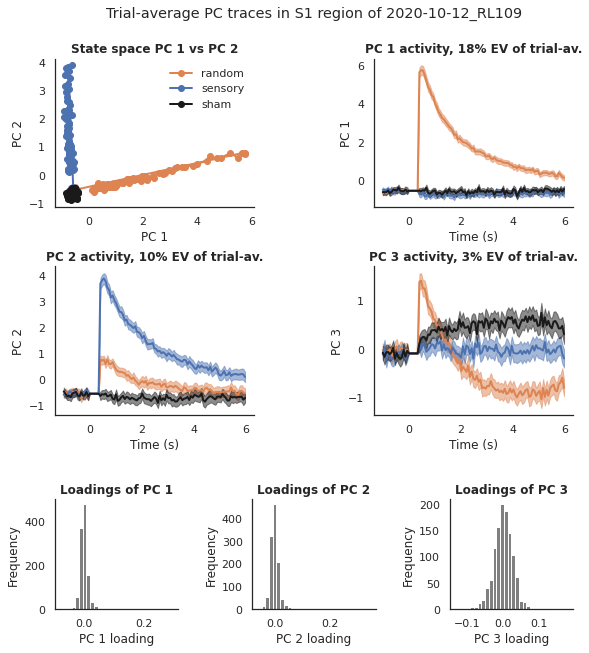

In [161]:
for sid in range(6):
    tmp = dav.SimpleSession(verbose=1, session_id=sid)
    dav.plot_pca_time_aggr_activity(Ses=tmp, trial_type_list=['sensory', 'random', 'sham'], 
                merge_trial_types_during_pca=True,
                save_fig=True, region='s1')

session name : 2021-02-18_RL127.pkl
Excluded 833 out of 2334 neurons
session name : 2021-02-22_RL128.pkl
Excluded 893 out of 2308 neurons
session name : 2021-02-23_RL129.pkl
Excluded 1323 out of 2364 neurons
session name : 2021-02-24_RL132.pkl
Excluded 757 out of 2156 neurons
session name : 2021-02-25_RL131.pkl
Excluded 1361 out of 2448 neurons
session name : 2021-03-02_RL130.pkl
Excluded 518 out of 2258 neurons


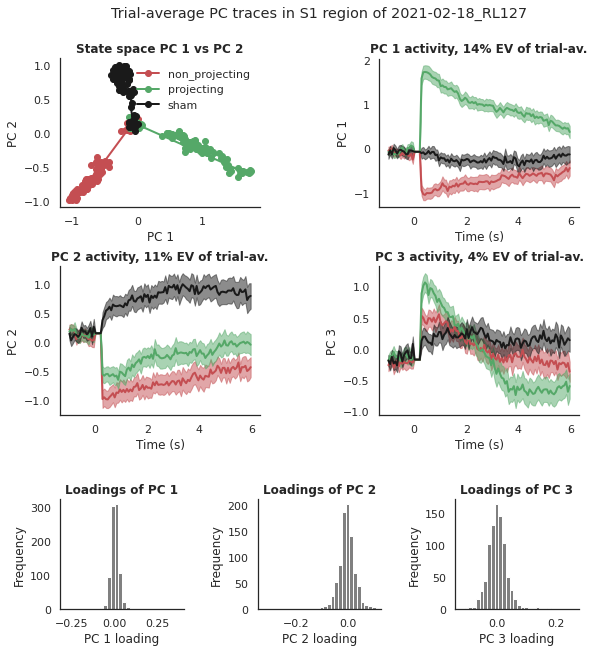

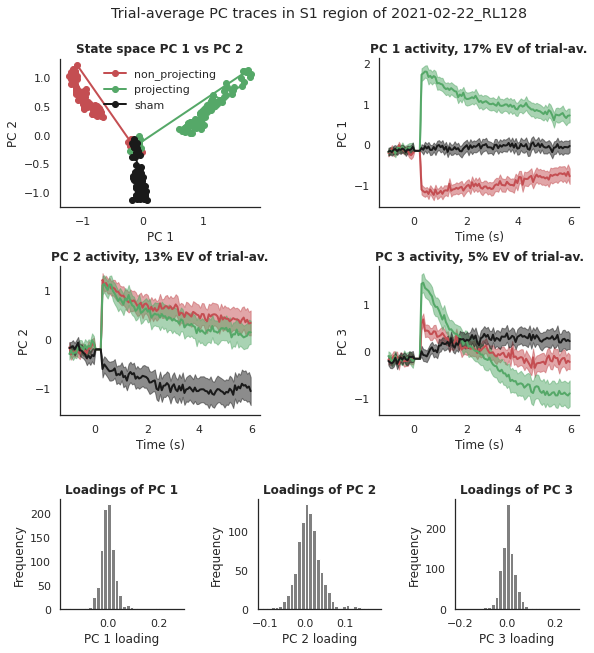

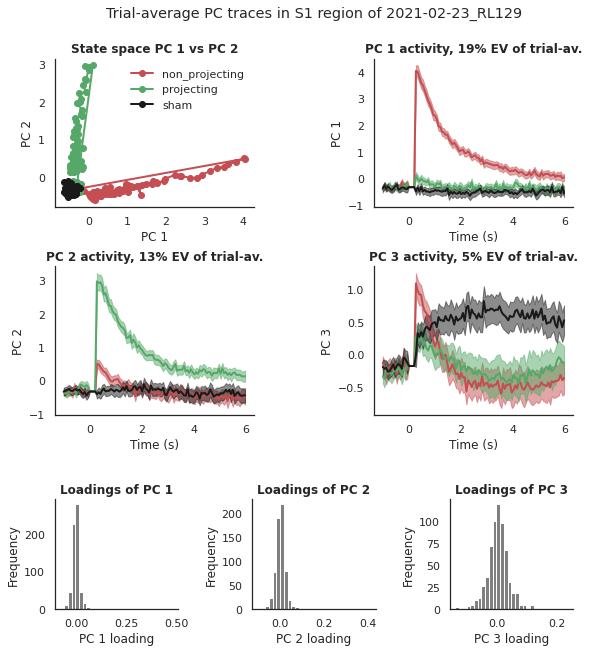

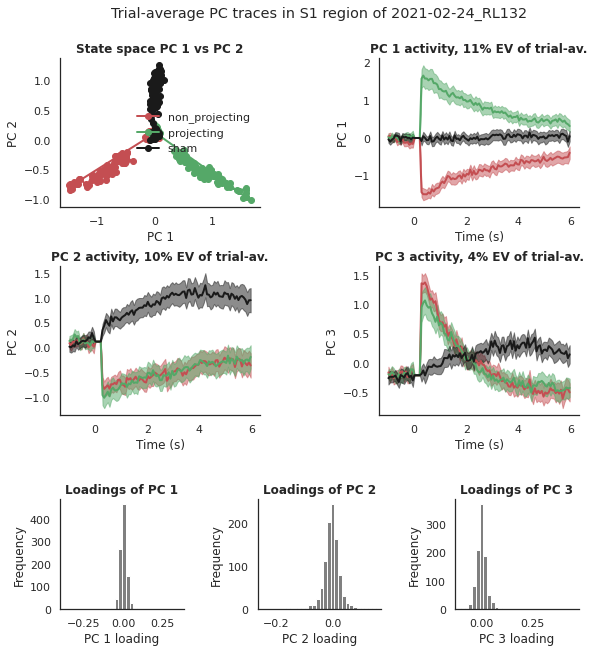

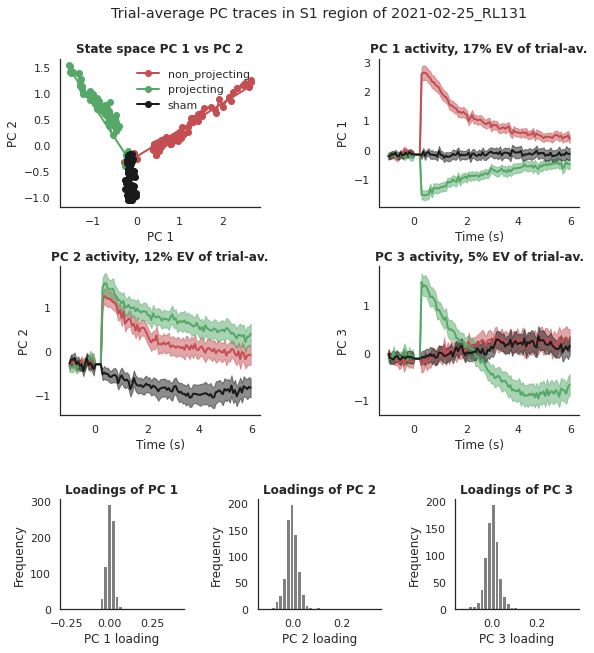

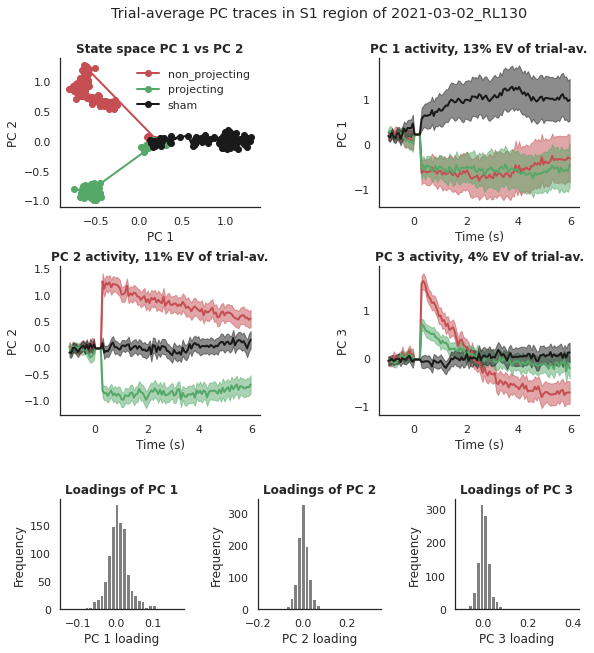

In [162]:
for sid in range(6):
    tmp = dav.SimpleSession(verbose=1, session_id=sid, sess_type='proj')
    dav.plot_pca_time_aggr_activity(Ses=tmp, trial_type_list=['projecting', 'non_projecting', 'sham'], merge_trial_types_during_pca=True,
                save_fig=True, region='s1')

Creating time aggregated data
<xarray.DataArray 'activity' (neuron: 774, trial: 400)>
array([[ 0.18858987,  0.46685526, -0.27100036, ...,  0.00693167,
         0.24362576, -0.05349078],
       [-0.1178965 ,  0.041265  ,  1.3447437 , ...,  0.20414238,
         0.21095489, -0.05407786],
       [ 2.7483902 ,  0.07292317, -0.05263437, ..., -0.11384263,
         0.29225054,  0.10344386],
       ...,
       [-0.30561945, -0.8211035 ,  0.66734767, ...,  0.03663945,
         0.15815401, -0.19727594],
       [ 0.33432612, -0.02919719,  0.3376851 , ...,  0.013749  ,
         0.21300723,  0.05832117],
       [-0.14707439, -0.5607916 , -0.18091242, ...,  0.426524  ,
         0.15785117,  0.17091493]], dtype=float32)
Coordinates:
  * neuron   (neuron) int64 1 3 4 5 6 7 11 ... 1780 1782 1785 1787 1791 1794
  * trial    (trial) int64 0 1 2 3 4 5 6 7 8 ... 392 393 394 395 396 397 398 399
['sensory', 'random', 'sham', 'whisker']
Neurons sorted by euclidean


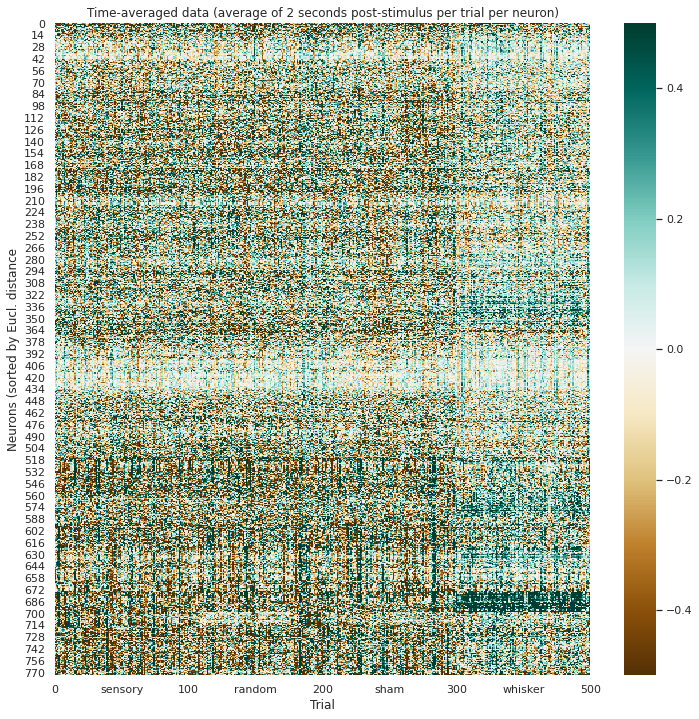

In [86]:
ax = dav.plot_raster_sorted_activity(Ses=tmp, create_new_time_aggr_data=True, 
                        sort_here=True,
                    plot_trial_type_list=['sensory', 'random', 'whisker', 'sham'])

In [84]:
[[0, 1], [2, 3]].()

AttributeError: 'list' object has no attribute 'join'

[0.04691993 0.01363621 0.01130082]
Subtracted LFA.


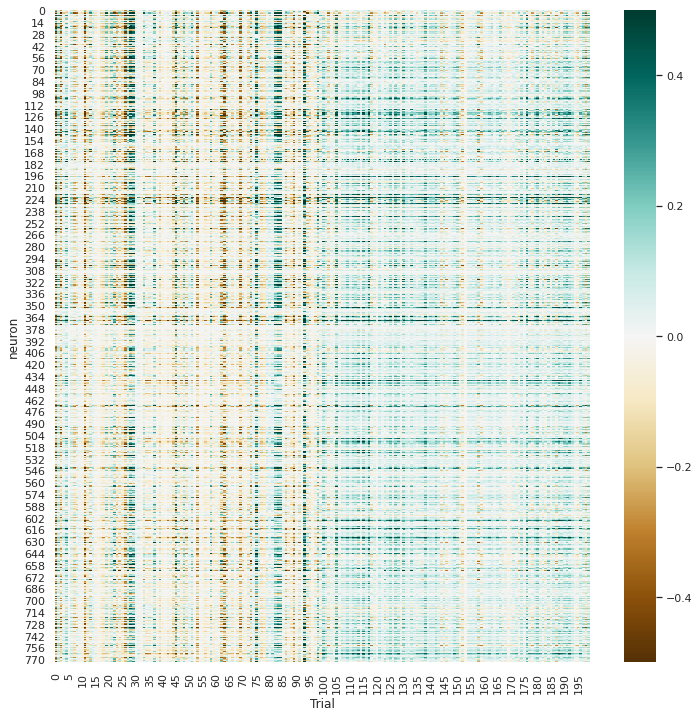

In [7]:
dav.plot_raster_sorted_activity(Ses=tmp)

In [5]:
tmp.find_all_discr_inds(region='s2')

Creating time-aggregate data set
Calculating d prime values


Shuffled discr not found!
Shuffled discr not found!
Shuffled discr not found!


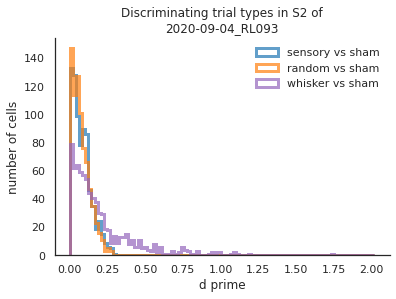

In [6]:
dav.plot_hist_discr(Ses=tmp, plot_density=False)

In [5]:
tmp.population_tt_decoder(tt_list=['whisker', 'sham'])

Time-aggregated activity object created
Decoder Cv loop 1/5
Score: 0.925
Decoder Cv loop 2/5
Score: 1.0
Decoder Cv loop 3/5
Score: 0.95
Decoder Cv loop 4/5
Score: 0.95
Decoder Cv loop 5/5
Score: 0.875
[0.925 1.    0.95  0.95  0.875]


In [7]:
# fig, ax = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
# i_row, i_col = 0, 0
dict_sess_type_tt = {'sens': ['sensory', 'random', 'whisker'],
                     'proj': ['projecting', 'non_projecting']}
decoder_type = 'LDA'
n_sessions = 6
scores_dict = {}
for i_r, region in enumerate(['s1', 's2']):
    scores_dict[region] = {}
    for sess_type, tt_test_list in dict_sess_type_tt.items():
        print(f'Session type: {sess_type} in region {region}')
        scores_dict[region][sess_type] = {tt: np.zeros(n_sessions) for tt in tt_test_list}
        for i_s in tqdm(range(n_sessions)):
            tmp = dav.SimpleSession(verbose=0, session_id=i_s, sess_type=sess_type,
                                    prestim_baseline=False)
            for i_tt, tt in enumerate(tt_test_list):
                tmp_score_arr = tmp.population_tt_decoder(tt_list=[tt, 'sham'], region=region,
                                                            verbose=0, decoder_type=decoder_type,
                                                            t_min=0.9, t_max=1.4)
                scores_dict[region][sess_type][tt][i_s] = np.mean(tmp_score_arr)


  0%|          | 0/6 [00:00<?, ?it/s]

Session type: sens in region s1


 17%|█▋        | 1/6 [01:33<07:45, 93.05s/it]

In [5]:
scores_dict

{'s1': {'sens': {'sensory': array([0.485, 0.395, 0.55 , 0.52 , 0.88 , 0.775]),
   'random': array([0.735, 0.47 , 0.58 , 0.82 , 0.905, 0.97 ]),
   'whisker': array([0.505, 0.51 , 0.555, 0.54 , 0.57 , 0.565])},
  'proj': {'projecting': array([0.395, 0.41 , 0.725, 0.545, 0.595, 0.48 ]),
   'non_projecting': array([0.35 , 0.33 , 0.855, 0.595, 0.62 , 0.51 ])}},
 's2': {'sens': {'sensory': array([0.185, 0.215, 0.27 , 0.385, 0.435, 0.545]),
   'random': array([0.16 , 0.325, 0.43 , 0.405, 0.46 , 0.545]),
   'whisker': array([0.52 , 0.535, 0.565, 0.615, 0.57 , 0.575])},
  'proj': {'projecting': array([0.395, 0.335, 0.435, 0.415, 0.415, 0.285]),
   'non_projecting': array([0.31 , 0.25 , 0.375, 0.47 , 0.39 , 0.225])}}}

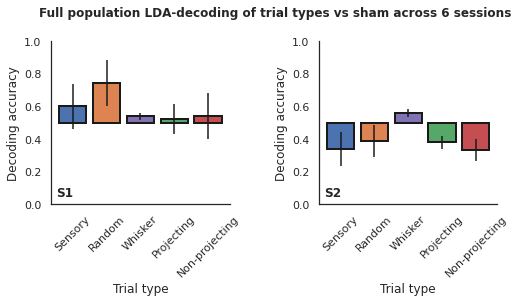

In [6]:
dav.bar_plot_decoder_accuracy(scores_dict=scores_dict)

Neurons sorted by sum
Neurons sorted by sum
Neurons sorted by sum
Neurons sorted by sum
Neurons sorted by sum
Neurons sorted by sum
Neurons sorted by sum
Neurons sorted by sum


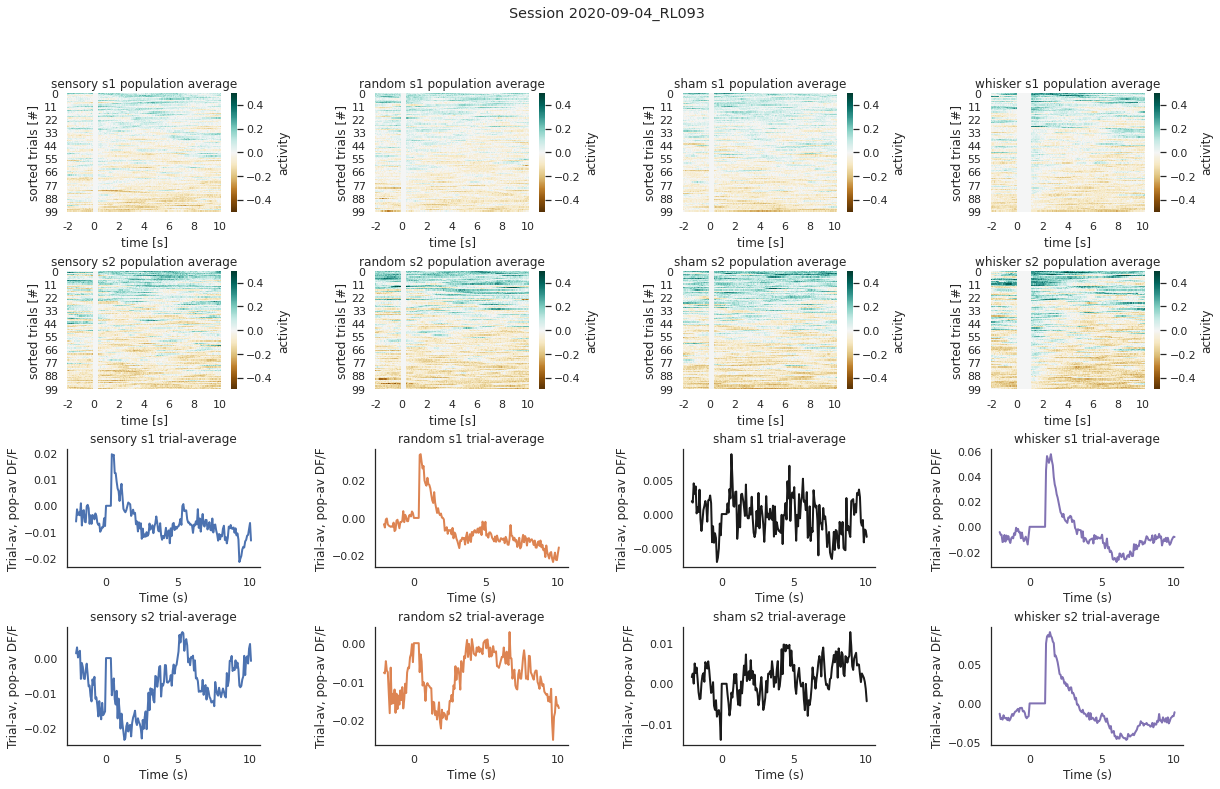

In [89]:
tmps = dav.plot_pop_av(Ses=tmp, region_list=['s1', 's2'], sort_trials_per_tt=True,
                        plot_trial_av=True)

In [34]:
tmpsort, tmprevsort = tmp.sort_neurons(data=tmps.data)



Neurons sorted by sum


# Compare baselined vs non-baselined data

In [3]:
ses_dict = {}
for bas in ['base', 'non-base']:
    ses_dict[bas] = dav.SimpleSession(verbose=1, session_id=0, 
                            shuffle_trial_labels=False,
                            shuffle_timepoints=False,
                            shuffle_all_data=False,
                            prestim_baseline=(bas == 'base'),
                            bool_filter_neurons=True)



session name : 2020-09-04_RL093.pkl
Excluded 302 out of 2097 neurons
session name : 2020-09-04_RL093.pkl
Excluded 302 out of 2097 neurons


Text(0.5, 1.0, 'Pre-stim vs post-stim activity of session 2020-09-04_RL093')

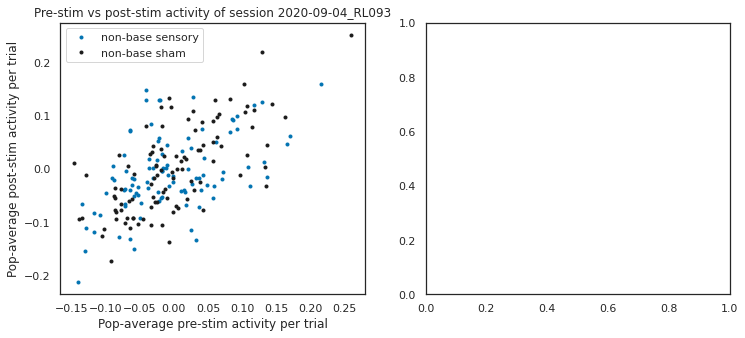

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
act = {}
for i_bas, bas in enumerate(['base', 'non-base']):
    if bas == 'base':
        continue
    # plot_data = ses_dict[bas].full_ds.activity.isel(trial=310).where(ses_dict[bas].full_ds.neuron < 30, drop=True)
    # plot_data = ses_dict[bas].full_ds.activity.where(ses_dict[bas].full_ds.trial < 300, drop=True).mean('neuron').transpose()
    # sns.heatmap(plot_data, ax=ax[i_bas], vmin=-0.2, vmax=0.2, cmap='BrBG')
    # ax[i_bas].set_title(bas)

    plot_data = ses_dict[bas].full_ds.activity.where(ses_dict[bas].full_ds.trial_type == 'sensory', drop=True).mean('neuron').transpose()
    ax[0].plot(plot_data[:, :31].mean('time'), plot_data[:, 40:70].mean('time'), '.', label=bas + ' sensory')


    plot_data = ses_dict[bas].full_ds.activity.where(ses_dict[bas].full_ds.trial_type == 'sham', drop=True).mean('neuron').transpose()
    ax[0].plot(plot_data[:, :31].mean('time'), plot_data[:, 40:70].mean('time'), '.', label=bas + ' sham', c='k')
#     act[bas] = ses_dict[bas].dataset_selector(region='s2', trial_type_list=['random'])
#     act[bas] = act[bas].activity.mean('neuron').transpose()
#     act[bas] = act[bas].data.mean(0)
#     ax[0].plot(act[bas], label=bas)
# ax[1].plot([-0.025, 0.025], [-0.025, 0.025], c='k')
# ax[1].plot(act['base'], act['non-base'], '.')
ax[0].legend()
ax[0].set_xlabel('Pop-average pre-stim activity per trial')
ax[0].set_ylabel('Pop-average post-stim activity per trial')
ax[0].set_title(f'Pre-stim vs post-stim activity of session {ses_dict[bas].session_name_readable}')

In [37]:
np.corrcoef(plot_data[:, :30].mean('time'), plot_data[:, 40:70].mean('time'), '.')

array([[1.        , 0.67045128],
       [0.67045128, 1.        ]])

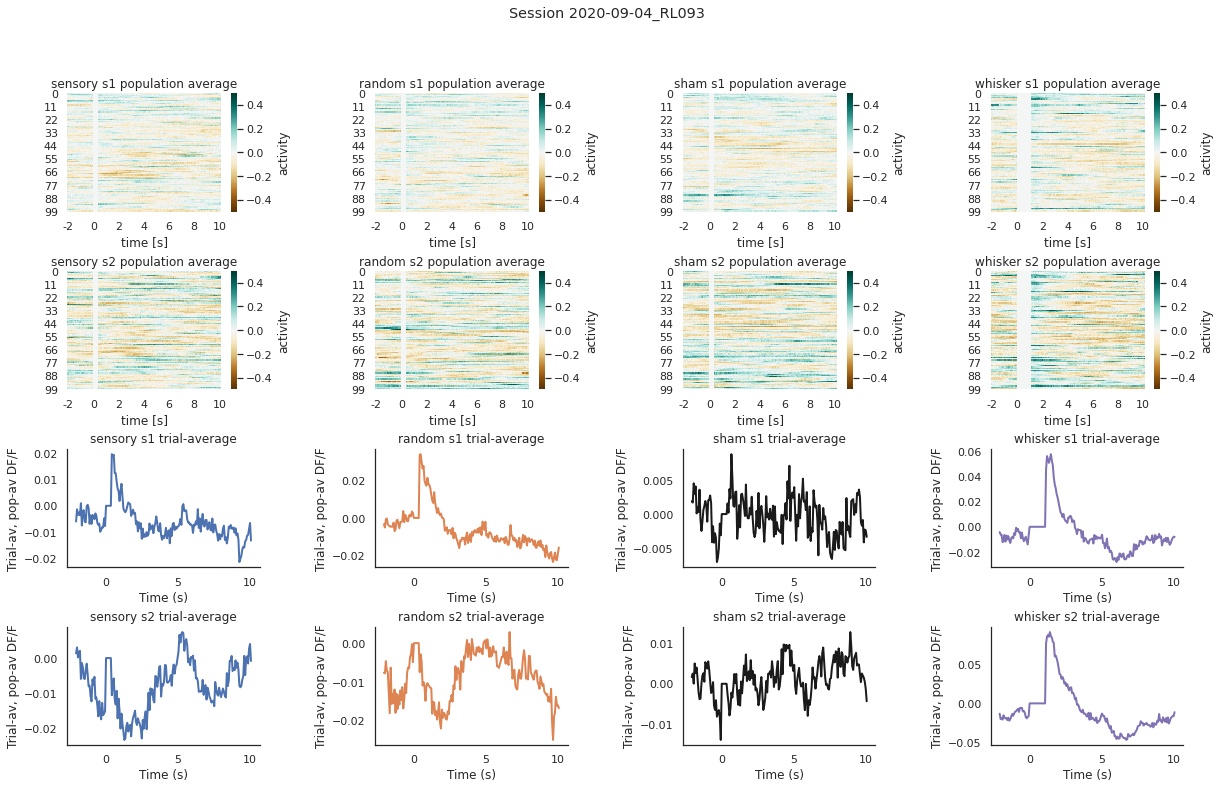

In [19]:
tmps = dav.plot_pop_av(Ses=ses_dict['non-base'], region_list=['s1', 's2'], sort_trials_per_tt=False,
                        plot_trial_av=True)

In [18]:
ses_dict['non-base'].

# Single cell decoding

100%|██████████| 6/6 [02:10<00:00, 21.68s/it]


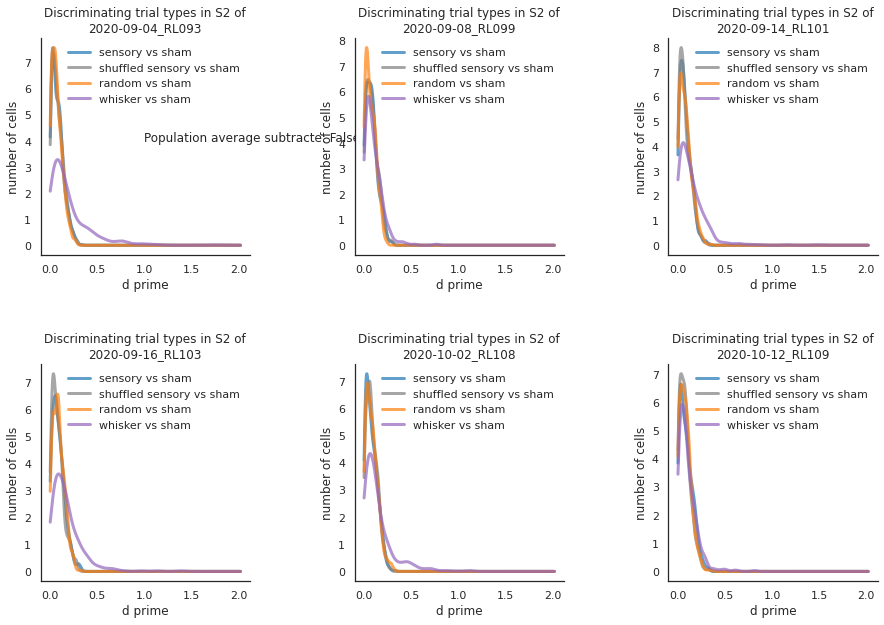

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
i_row, i_col = 0, 0
for i_s in tqdm(range(6)):
    tmp = dav.SimpleSession(verbose=0, session_id=i_s)
    tmp.find_all_discr_inds(region='s2', shuffled=True)
    dav.plot_hist_discr(Ses=tmp, plot_density=False, ax=ax[i_row, i_col],
                        yscale_log=False, plot_hist=False, plot_kde=True,
                        show_all_shuffled=False)

    if i_row == 0 and i_col == 0:
        ax[i_row, i_col].text(x=1, y=4, s=f'Population average subtracte: {tmp.time_aggr_ds_pop_av_subtracted}')
    i_col += 1
    # break
    if i_col == 3:
        i_row += 1
        i_col = 0

100%|██████████| 6/6 [01:44<00:00, 17.41s/it]


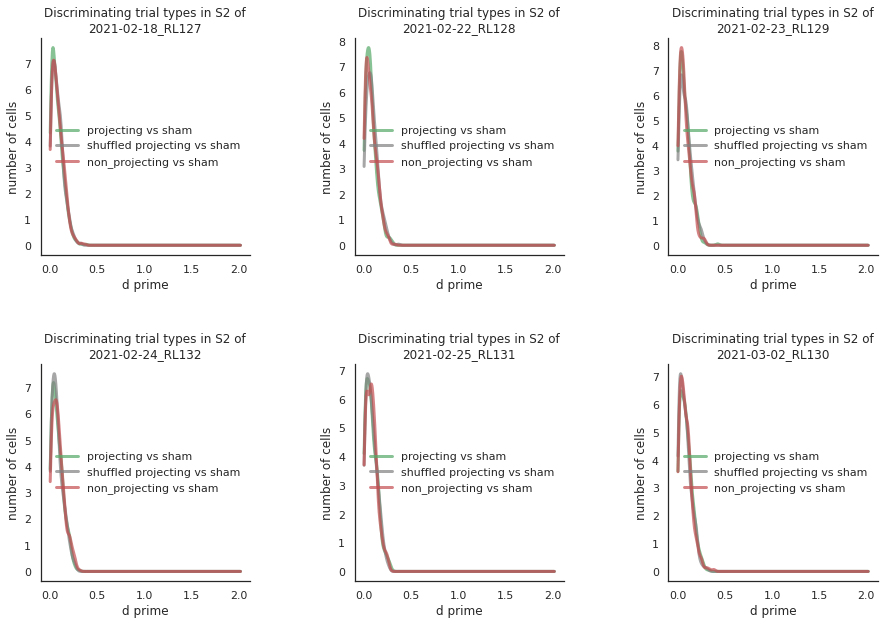

In [57]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
i_row, i_col = 0, 0
for i_s in tqdm(range(6)):
    tmp = dav.SimpleSession(verbose=0, session_id=i_s, sess_type='proj')
    tmp.find_all_discr_inds(region='s2', shuffled=True)
    dav.plot_hist_discr(Ses=tmp, plot_density=False, ax=ax[i_row, i_col],
                        plot_hist=False, plot_kde=True, show_all_shuffled=False)
    i_col += 1
    if i_col == 3:
        i_row += 1
        i_col = 0

100%|██████████| 6/6 [03:58<00:00, 39.82s/it]


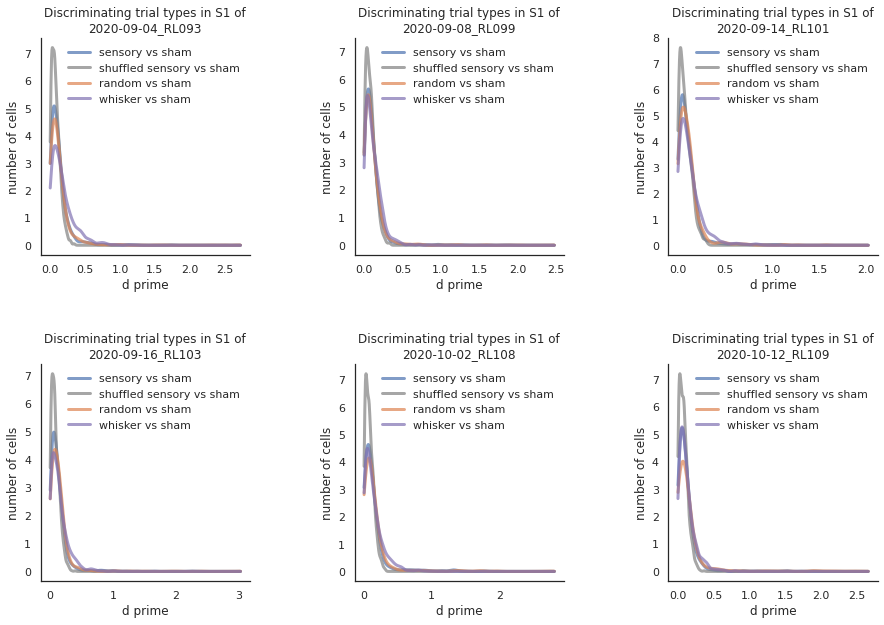

In [58]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
i_row, i_col = 0, 0
for i_s in tqdm(range(6)):
    tmp = dav.SimpleSession(verbose=0, session_id=i_s, sess_type='sens')
    tmp.find_all_discr_inds(region='s1', shuffled=True)
    dav.plot_hist_discr(Ses=tmp, plot_density=False, ax=ax[i_row, i_col],
                        plot_hist=False, plot_kde=True, yscale_log=False)
    i_col += 1
    if i_col == 3:
        i_row += 1
        i_col = 0

100%|██████████| 6/6 [02:28<00:00, 24.67s/it]


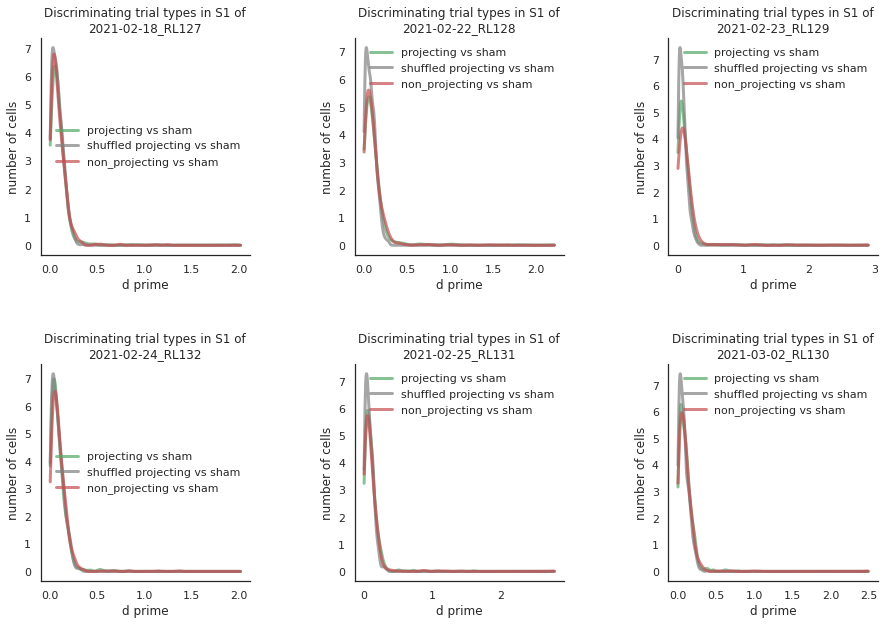

In [60]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
i_row, i_col = 0, 0
for i_s in tqdm(range(6)):
    tmp = dav.SimpleSession(verbose=0, session_id=i_s, sess_type='proj')
    tmp.find_all_discr_inds(region='s1', shuffled=True)
    dav.plot_hist_discr(Ses=tmp, plot_density=False, ax=ax[i_row, i_col],
                        plot_hist=False, plot_kde=True, show_all_shuffled=False)
    i_col += 1
    if i_col == 3:
        i_row += 1
        i_col = 0

In [122]:
for tt in ['whisker', 'sensory']:
    for bool_spcs in [True, False]:
        tmp_score_arr = tmp.population_tt_decoder(tt_list=[tt, 'sham'], region='s2',
                                                    verbose=0, decoder_type='LDA',
                                                     subtract_pcs=bool_spcs)
        print(f'{tt} vs sham, {bool_spcs} subtraction PCS')
        print(tmp_score_arr)
        print('----\n')



[0.0502188  0.02004048 0.01212633]
Subtracted LFA.
whisker vs sham, True subtraction PCS
[0.4   0.525 0.55  0.675 0.4  ]
----

whisker vs sham, False subtraction PCS
[0.925 1.    0.95  0.95  0.875]
----

[0.04808933 0.0132045  0.01020422]
Subtracted LFA.
sensory vs sham, True subtraction PCS
[0.5   0.5   0.35  0.525 0.425]
----

sensory vs sham, False subtraction PCS
[0.65  0.575 0.55  0.475 0.55 ]
----



In [123]:
for tt in ['whisker', 'sensory']:
    for bool_spcs in [True, False]:
        tmp_score_arr = tmp.population_tt_decoder(tt_list=[tt, 'sham'], region='s2',
                                                    verbose=0, decoder_type='LDA',
                                                     subtract_pcs=bool_spcs)
        print(f'{tt} vs sham, {bool_spcs} PC activity only')
        print(tmp_score_arr)
        print('----\n')



[0.05021881 0.02004049 0.01212616]
Subtracted LFA.
whisker vs sham, True PC activity only
[0.9   0.95  0.925 0.85  0.825]
----

whisker vs sham, False PC activity only
[0.925 1.    0.95  0.95  0.875]
----

[0.04808929 0.01320452 0.01020572]
Subtracted LFA.
sensory vs sham, True PC activity only
[0.475 0.4   0.625 0.45  0.5  ]
----

sensory vs sham, False PC activity only
[0.65  0.575 0.55  0.475 0.55 ]
----

